In [256]:
import torch
from torch.optim import SGD, Adam
import torch.nn as nn


from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import numpy as np

In [257]:
INPUT_DIMENSION=10
OUTPUT_DIMENSION=1
NUMBER_OF_SAMPLES=1000
EPOCHS=20
LR=0.01

In [258]:
X,y=make_blobs(n_samples=1000, n_features=INPUT_DIMENSION, centers=2, random_state=1)

# Make the categories +/-1 rather thn 0,1
y=2*y-1 

# Transform the entries to have norm less than or equal to 1
X=X/max([np.linalg.norm(x) for x in X]) 

# Split data into train and test
(trainX, testX, trainY, testY) = train_test_split(X, y,test_size=0.15)
trainX = torch.from_numpy(trainX).float()
testX = torch.from_numpy(testX).float()
trainY = torch.from_numpy(trainY).float()
testY = torch.from_numpy(testY).float()

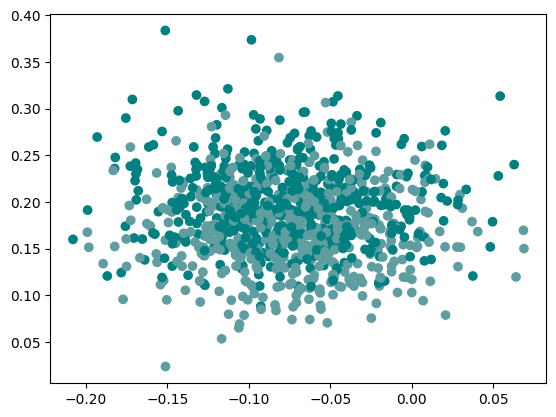

In [259]:
colors=np.full(len(y), 'cadetblue')
colors[y==-1]='teal'
plt.scatter(X[:,0],X[:,1],c=colors)

In [260]:
class LinearClassifier(torch.nn.Module):
  def __init__(self, input_dim=INPUT_DIMENSION, output_dim=OUTPUT_DIMENSION):
    super(LinearClassifier, self).__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim, bias=False)

  def forward(self, x):
    x = self.linear(x)
    return x

In [261]:
def next_batch(inputs, targets, batchSize):
	for i in range(0, inputs.shape[0], batchSize):
		yield (inputs[i:i + batchSize], targets[i:i + batchSize])

In [262]:
model=LinearClassifier()

In [263]:
# Train the model

opt = Adam(model.parameters(), lr=LR)
lossFunc = nn.L1Loss()

for epoch in range(0, 20):
	trainLoss = 0
	trainAcc = 0
	samples = 0
	model.train()
	for (batchX, batchY) in next_batch(trainX, trainY, 1):
		predictions = model(batchX)
		loss = lossFunc(predictions, batchY.long())
		opt.zero_grad()
		loss.backward()
		opt.step()
		trainLoss += loss.item() * batchY.size(0)
		trainAcc += (torch.sign(predictions) == batchY).sum().item()
		samples += batchY.size(0)
	print("Epoch: {} train loss: {:.3f} train accuracy: {:.3f}".format(epoch+1,trainLoss / samples,trainAcc / samples))

c:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 1 train loss: 0.164 train accuracy: 0.976
Epoch: 2 train loss: 0.090 train accuracy: 1.000
Epoch: 3 train loss: 0.089 train accuracy: 1.000
Epoch: 4 train loss: 0.089 train accuracy: 1.000
Epoch: 5 train loss: 0.089 train accuracy: 1.000
Epoch: 6 train loss: 0.089 train accuracy: 1.000
Epoch: 7 train loss: 0.089 train accuracy: 1.000
Epoch: 8 train loss: 0.089 train accuracy: 1.000
Epoch: 9 train loss: 0.090 train accuracy: 1.000
Epoch: 10 train loss: 0.089 train accuracy: 1.000
Epoch: 11 train loss: 0.090 train accuracy: 1.000
Epoch: 12 train loss: 0.089 train accuracy: 1.000
Epoch: 13 train loss: 0.089 train accuracy: 1.000
Epoch: 14 train loss: 0.089 train accuracy: 1.000
Epoch: 15 train loss: 0.089 train accuracy: 1.000
Epoch: 16 train loss: 0.089 train accuracy: 1.000
Epoch: 17 train loss: 0.089 train accuracy: 1.000
Epoch: 18 train loss: 0.089 train accuracy: 1.000
Epoch: 19 train loss: 0.089 train accuracy: 1.000
Epoch: 20 train loss: 0.089 train accuracy: 1.000


In [264]:
# Normalizing the decision vector

for param in model.parameters():
    decision_vector=param[0].tolist()
    decision_vector=decision_vector/np.linalg.norm(decision_vector)
model.linear.weight=torch.nn.Parameter(torch.from_numpy(decision_vector).float())

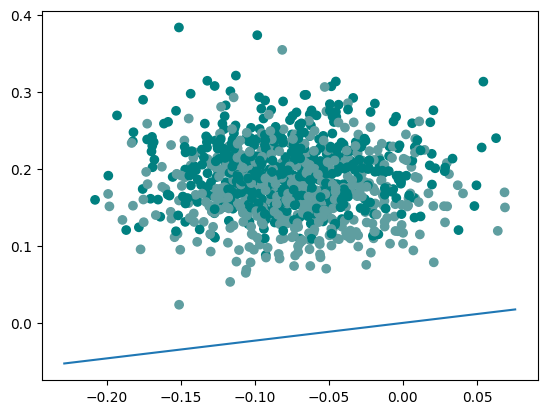

In [265]:
# Decision boundary projected onto first two coordinates

x=np.array([min(X[:,0])*1.1,max(X[:,0])*1.1])
grad=decision_vector[1]/decision_vector[0]
plt.plot(x,-x/grad)
plt.scatter(X[:,0],X[:,1],c=colors)

In [266]:
# Calculating the margin of the classifier

with torch.no_grad():
    for batchX, batchY in next_batch(testX, testY, len(testX)):
        predictions = model(batchX)
        margin=min(abs(predictions)).tolist()
print(margin)

0.33684733510017395


In [267]:
# Compressing the decision as per the algorithm

compressed_decision_vector=np.zeros(len(decision_vector))
for k, comp in enumerate(decision_vector):
    p=8*comp**2/margin**2
    if np.random.random()<p:
        compressed_decision_vector[k]=margin**2/(8*comp)

In [268]:
print('Original Classifier: {}'.format(decision_vector))
print('Compressed Classifier: {}'.format(compressed_decision_vector))
print('Rate of compression: {}%'.format(100*sum(compressed_decision_vector==0)/len(decision_vector)))

Original Classifier: [ 0.00894124 -0.03878107  0.17939068  0.55646174 -0.10000631  0.58058108
  0.16480878  0.29253799 -0.23684661 -0.37506403]
Compressed Classifier: [ 0.          0.          0.07906356  0.0254883  -0.14182371  0.02442943
  0.08605892  0.0484835  -0.05988376 -0.03781559]
Rate of compression: 20.0%


C:\Users\thoma\AppData\Local\Temp\ipykernel_22868\3411547079.py:3: RuntimeWarning: invalid value encountered in double_scalars
  compressed_grad=compressed_decision_vector[1]/compressed_decision_vector[0]


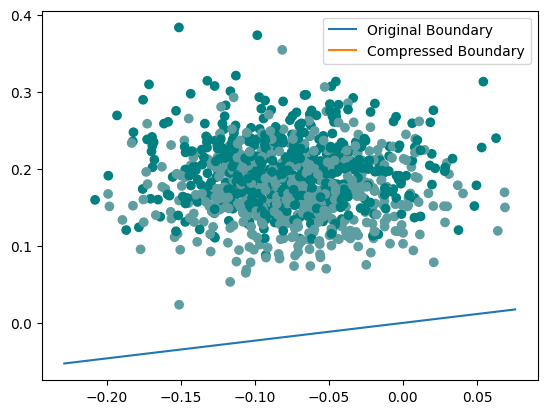

In [269]:
# Compressed decision boundary projected onto first two coordinates

compressed_grad=compressed_decision_vector[1]/compressed_decision_vector[0]
plt.plot(x,-x/grad,label='Original Boundary')
plt.plot(x,-x/compressed_grad,label='Compressed Boundary')
plt.scatter(X[:,0],X[:,1],c=colors)
plt.legend()

In [270]:
# Creating new model with compressed classifier

compressed_model=LinearClassifier()
compressed_model.linear.weight=torch.nn.Parameter(torch.from_numpy(compressed_decision_vector).float())

In [272]:
original_testAcc=0
samples=0
with torch.no_grad():
    for (batchX, batchY) in next_batch(testX, testY, 1):
        predictions = model(batchX)
        original_testAcc += (torch.sign(predictions) == batchY).sum().item()
        samples += batchY.size(0)
original_testError=original_testAcc/samples

compressed_testAcc=0
samples=0
with torch.no_grad():
    for (batchX, batchY) in next_batch(testX, testY, 1):
        predictions = compressed_model(batchX)
        compressed_testAcc += (torch.sign(predictions) == batchY).sum().item()
        samples += batchY.size(0)
compressed_testError=compressed_testAcc/samples
print('Original Model Test Error: {} Compressed Model Test Error: {}'.format(original_testError,compressed_testError))

Original Model Test Error: 1.0 Compressed Model Test Error: 1.0
